<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/13_ViT/CatsAndDogs_ViT/Cats_Dogs_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers with PyTorch

With the blog reference: [Cats&Dogs viT hands on blog](https://analyticsindiamag.com/hands-on-vision-transformers-with-pytorch/), exploring the ViT code in PyTorch to train dogs and cats classification

[Dataset](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) We will be implementing the code for Vision Transformers with PyTorch using [vit_pytorch package](https://github.com/lucidrains/vit-pytorch) and  and Linformer 

In [8]:
pip install vit-pytorch linformer

**How it works** </br>
ViT breaks an input image of 16×16 to a  sequence of patches, just like a series of word embeddings generated by an NLP Transformers. Each patch gets flattened into a single vector in a series of interconnected channels of all pixels in a patch, then projects it to desired input dimension. Because transformers operate in self-attention mode, and they do not necessarily depend on the structure of the input elements, which in turns helps the architecture to learn and relate sparsely-distributed information more efficiently. In Vit, the relationship between the patches in an image is not known and thus allows it to learn more relevant features from the training data and encode in positional embedding in ViT. 

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyakamat","key":"086f4df84c71338fea40a9a7c43c3ca1"}'}

## Loading Kaggle dataset:
https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [6]:
!pwd

/content


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 97% 264M/271M [00:02<00:00, 118MB/s]
100% 271M/271M [00:02<00:00, 131MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 52.9MB/s]
 99% 540M/544M [00:04<00:00, 159MB/s]
100% 544M/544M [00:04<00:00, 138MB/s]


In [9]:
# loading Libraries

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   


# import Linformer

from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function
# import torch and related libraries 

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile   
#sklearn to split the data

from sklearn.model_selection import train_test_split  

In [10]:
#definining batch size, epocs, learning rate and gamma for training  

batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 
#Load data

os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

In [11]:
#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

In [12]:
#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [13]:
#Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

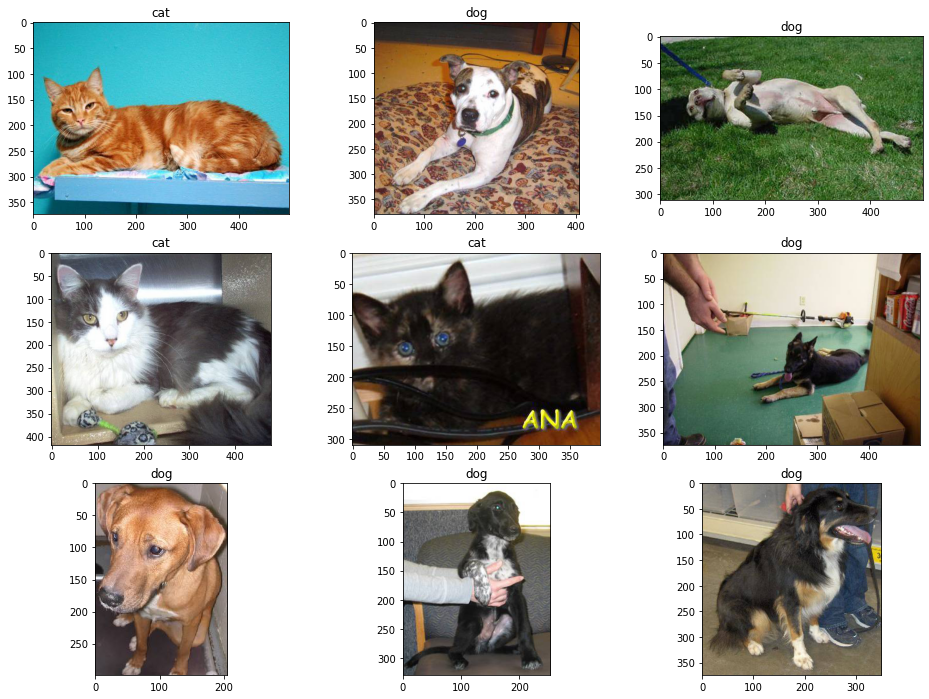

In [14]:
# printing few images 

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [16]:
seed = 40

In [17]:
#Splitting train and validation list

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [18]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [19]:
#Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [20]:
#defining train, validation and test dataset
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)
#loading dataloader

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [21]:
#Line transformer 
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [25]:
#Visual transformer 
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [26]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [27]:
#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.6991 - acc: 0.5018 - val_loss : 0.6915 - val_acc: 0.5336




Epoch : 2 - loss : 0.6911 - acc: 0.5228 - val_loss : 0.6882 - val_acc: 0.5380




Epoch : 3 - loss : 0.6871 - acc: 0.5390 - val_loss : 0.6773 - val_acc: 0.5750




Epoch : 4 - loss : 0.6765 - acc: 0.5755 - val_loss : 0.6693 - val_acc: 0.5896




Epoch : 5 - loss : 0.6716 - acc: 0.5765 - val_loss : 0.6615 - val_acc: 0.5971




Epoch : 6 - loss : 0.6593 - acc: 0.5981 - val_loss : 0.6509 - val_acc: 0.6125




Epoch : 7 - loss : 0.6502 - acc: 0.6082 - val_loss : 0.6425 - val_acc: 0.6258




Epoch : 8 - loss : 0.6424 - acc: 0.6210 - val_loss : 0.6353 - val_acc: 0.6252




Epoch : 9 - loss : 0.6343 - acc: 0.6331 - val_loss : 0.6283 - val_acc: 0.6357




Epoch : 10 - loss : 0.6283 - acc: 0.6399 - val_loss : 0.6211 - val_acc: 0.6456




Epoch : 11 - loss : 0.6203 - acc: 0.6487 - val_loss : 0.6211 - val_acc: 0.6517




Epoch : 12 - loss : 0.6135 - acc: 0.6568 - val_loss : 0.6187 - val_acc: 0.6473




Epoch : 13 - loss : 0.6066 - acc: 0.6612 - val_loss : 0.6128 - val_acc: 0.6555




Epoch : 14 - loss : 0.6028 - acc: 0.6640 - val_loss : 0.6094 - val_acc: 0.6606




Epoch : 15 - loss : 0.6011 - acc: 0.6678 - val_loss : 0.5980 - val_acc: 0.6778




Epoch : 16 - loss : 0.5951 - acc: 0.6760 - val_loss : 0.6032 - val_acc: 0.6705




Epoch : 17 - loss : 0.5917 - acc: 0.6780 - val_loss : 0.6124 - val_acc: 0.6632




Epoch : 18 - loss : 0.5912 - acc: 0.6780 - val_loss : 0.5921 - val_acc: 0.6792




Epoch : 19 - loss : 0.5877 - acc: 0.6834 - val_loss : 0.5954 - val_acc: 0.6764




Epoch : 20 - loss : 0.5878 - acc: 0.6823 - val_loss : 0.6147 - val_acc: 0.6638

